# important links


## list:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels?sortBy=voteCount&group=everyone&pageSize=20&language=Python&competitionId=5407


## xgboost:
https://www.kaggle.com/dansbecker/xgboost

https://medium.com/@gabrieltseng/gradient-boosting-and-xgboost-c306c1bcfaf5



## regration + graph :
https://www.kaggle.com/janiobachmann/predicting-house-prices-regression-techniques


## Selecting and Filtering Data
https://www.kaggle.com/dansbecker/selecting-and-filtering-in-pandas

## Handling Missing Values
https://www.kaggle.com/dansbecker/handling-missing-values



## why use conditional probability coding
https://medium.com/airbnb-engineering/designing-machine-learning-models-7d0048249e69

## one hot encoding
https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f


# Imports:

In [52]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
%matplotlib inline

# Data Management

### Load Data

In [53]:
train = pd.read_csv('train.csv')#.select_dtypes(exclude=['object'])
test = pd.read_csv('test.csv')#.select_dtypes(exclude=['object'])

#look into datatypes of the file
print("data types count")
train.dtypes.groupby(train.dtypes).count()


data types count


int64      35
float64     3
object     43
dtype: int64

In [54]:
#selecting target
train_target = train.SalePrice
#the last column is the SalePrice coloumn so removing it from the list
predictor_cols = train.drop(train.columns[-1],axis=1)
# droping id
predictor_cols = predictor_cols.drop('Id',axis=1)
predictor_cols_test = test.drop('Id',axis=1)


### Looking into data

In [55]:
print('show sample')
train.head()

show sample


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [56]:
print('description of data')
train.describe()

description of data


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Removing missing data

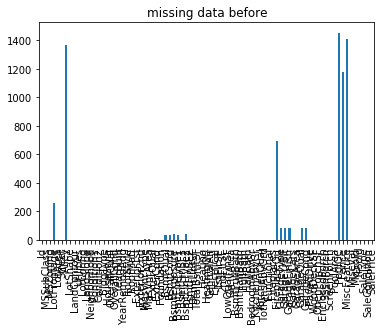

In [57]:
missing_data_col = train.isnull().sum()
missing_data_col.plot.bar(title = 'missing data before')
total_row = train.index.size
missing_data_list = missing_data_col[missing_data_col > total_row*.50].index
train = train.drop(missing_data_list,1)
# removing form kaggle test data also
test = test.drop(missing_data_list,1)

### One hot encoding
To encode categorical integer features as a one-hot numeric array we are using one hot encoding. This will transform each value of catagories into a features and make those a column value of dataframe. Finally put binary values in the rows of those column.

In [58]:
# for example:

# ╔════════════╦═════════════════╦════════╗ 
# ║ CompanyName Categoricalvalue ║ Price  ║
# ╠════════════╬═════════════════╣════════║ 
# ║ VW         ╬      1          ║ 20000  ║
# ║ Acura      ╬      2          ║ 10011  ║
# ║ Honda      ╬      3          ║ 50000  ║
# ║ Honda      ╬      3          ║ 10000  ║
# ╚════════════╩═════════════════╩════════╝

# converting it to one Hot encoding:

# ╔════╦══════╦══════╦════════╦
# ║ VW ║ Acura║ Honda║ Price  ║
# ╠════╬══════╬══════╬════════╬
# ║ 1  ╬ 0    ╬ 0    ║ 20000  ║
# ║ 0  ╬ 1    ╬ 0    ║ 10011  ║
# ║ 0  ╬ 0    ╬ 1    ║ 50000  ║
# ║ 0  ╬ 0    ╬ 1    ║ 10000  ║
# ╚════╩══════╩══════╩════════╝

# refrence: https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

In this section at first we merge train and test data (variable name predictor_cols and predictor_cols_test). We did it because there is some fetures in train data which is missing in test data again same thing can happen for test data too. 

In [59]:
def OneHotEncoding(all_data):
    enc = OneHotEncoder()
    
    all_data = enc.fit_transform(all_data)
    # all_data is no in scipy.sparse.csr.csr_matrix format converting it to 2d-numpy array
    all_data = all_data.toarray()
    all_data = pd.DataFrame(all_data, columns=enc.get_feature_names())
    return all_data



### Imputing missing data
    We are using simpleimputer and it uses mean by default. It will just replace those empty places with mean values.
    In this section we are impute missing coloumn where the missing data amount is less than 50%. 

In [60]:
def imputation(all_data):
    imputer_numb_col = SimpleImputer(strategy="most_frequent" , missing_values=np.nan )
    imputer_obj_col = SimpleImputer(strategy="most_frequent" , missing_values=np.nan )
    #excluding all object dtype column
    num_col = all_data.select_dtypes(exclude= ['object'])
    #excluding all number dtype column
    obj_col = all_data.select_dtypes(include=['object'])
    
    """ 
    fit_transform turns a df to numpy array so keeping the column name would be helpful for returning to df format
    """
    
    #imputing number part of df
    column_names = num_col.columns.values
    num_col = imputer_numb_col.fit_transform(num_col)
    # putting imputed values in the place of missing values of original detaframe 
    num_col = pd.DataFrame(num_col, columns = column_names)
    
    # imputing object part of df
    column_names = obj_col.columns.values
    obj_col = imputer_obj_col.fit_transform(obj_col)   
    obj_col = pd.DataFrame(obj_col,columns = column_names)
    
    """performing one hot encoding on obj_col dataframe"""
    obj_col = OneHotEncoding(obj_col)
    
    
    #combinin numb and obje part to all_data
    all_data = num_col.combine_first(obj_col)
    return all_data



In [61]:

"""One hot encoding is going to perform inside imputation function so we need """

# getting last index of training data
lenth_predictor_cols = len(predictor_cols)
#for performing one hot encoding we combine all data
all_data = predictor_cols.append(predictor_cols_test, ignore_index=True)

all_data = imputation(all_data)

# seperate the dataset again after performing one hot encoding
# nd array works diffrently than pandas df.loc[] 
predictor_cols = all_data[:lenth_predictor_cols]
predictor_cols_test = all_data[lenth_predictor_cols:]

### after imputation graphs

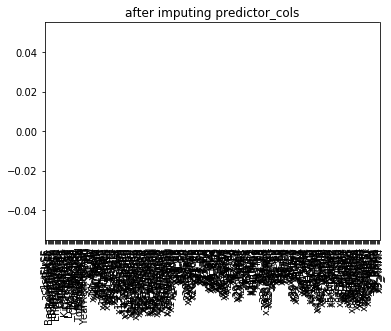

In [62]:
pd.DataFrame(predictor_cols).isnull().sum().plot.bar(title = "after imputing predictor_cols")

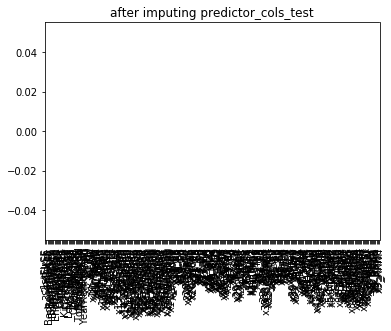

In [63]:
pd.DataFrame(predictor_cols_test).isnull().sum().plot.bar(title = "after imputing predictor_cols_test")

### Split Data for training and testing

In [64]:
X_train, X_test, y_train, y_test = train_test_split(predictor_cols, 
                                                    train_target,
                                                    train_size=0.8, 
                                                    test_size=0.2, 
                                                    random_state=1)

# Model selection

## Model selection

### Linear Regression

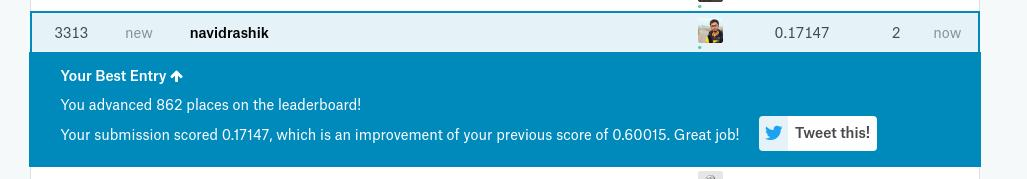

In [65]:
# my_model = LinearRegression()
Image("regression.jpg")

In [66]:
# from sklearn import svm
# my_model = svm.SVR()

In [67]:
# from sklearn.naive_bayes import GaussianNB
# my_model = GaussianNB()

### Random Forest Regressor

In [68]:
# my_model = RandomForestRegressor()

### DecisionTree

In [69]:
# from sklearn.tree import DecisionTreeRegressor
# my_model = DecisionTreeRegressor()

### Xgboost 

* for 2000, 0.15 =>
mean absolute error:  14802.790788206335
accuracy score:  0.9184459671731471

* for 1000, 0.15 =>
mean absolute error:  14738.404430650686
accuracy score:  0.9185264791078522

* for 500, 0.15 =>
mean absolute error:  14709.338639768835
accuracy score:  0.918560790678001
* for 500, 0.05 =>
mean absolute error:  13994.730268086472
accuracy score:  0.9276053252581928
* for 1500, 0.05 =>
mean absolute error:  13527.634270654966
accuracy score:  0.9320158574642144

* for 1000, .05 =>
mean absolute error:  13607.276487585616
accuracy score:  0.932101661947708

* for 3000, .05 =>
mean absolute error:  13605.092010916096
accuracy score:  0.9322736091885926

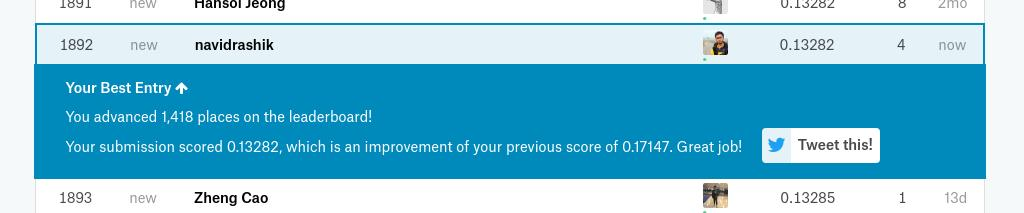

In [75]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)


Image("xgboost.jpg")

## Model fit on training set

In [71]:
my_model.fit(X_train, y_train)
prediction = my_model.predict(X_test)

## Model fit for test set

In [72]:
prediction_test = my_model.predict(predictor_cols_test)

# Acuracy Score

In [73]:
print('mean absolute error: ',mean_absolute_error(y_test, prediction))
print('accuracy score: ', my_model.score(X_test,y_test))

mean absolute error:  13605.092010916096
accuracy score:  0.9322736091885926


In addition to your training data, there will be test data. This is frequently stored in a file with the title `test.csv`. This data won't include a column with your target (y), because that is what we'll have to predict and submit.  Here is sample code to do that. 

# Prepare Submission File

In [74]:

my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': prediction_test})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)